# EE-411 Fundamentals of inference and learning, EPFL 
## Exercice Session 2: optimizing functions using scipy

In this second set of exercices, we will solve the so-called *Lighthouse problem*, which serves as a perfect opportunity to introduce a very useful package for scientific computing, called **scipy**.

**What you will learn today:** In this second session, we will discuss how to use **scipy** to generate random data according to a certain distribution and to minimize 1D and 2D functions. Furthermore, we will have a first-hand application of some concepts explained in the second lecture, such as the maximal likelihood estimator, Cramér–Rao bound and Jeffreys prior.


# The Lighthouse problem 

**Locating the lighthouse**

A lighthouse is located somewhere off a piece of straight coastline at a position $\alpha$ (or $x_0$) along the shore and a distance $\beta$ (or $y_0$) out at sea. It emits a series of short highly collimated flashes at random intervals and hence at random azimuths. These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came. N flashes have so far been recorded at positions $\{x_k\}$. Where is the lighthouse?’ (from D. Sivia's book, "Data Analysis - A Bayesian Tutorial")

[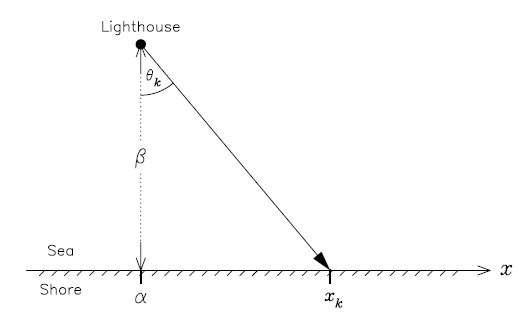](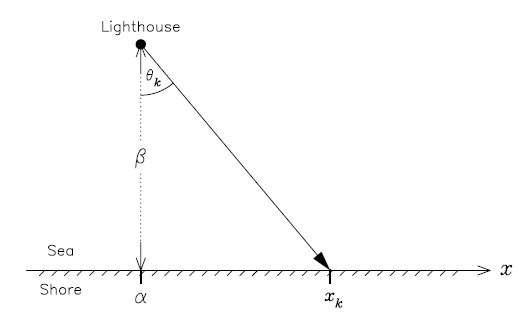)



##### 1) Compute the probability distribution $p(x | x_0,y_0)$ of observing a flash at the point $x$ along the shore depending on the distance of the lighthouse from the shore $y_0$ and its position along the shore $x_0$.

#### Recall: Maximum likelihood estimator


The maximum likelyhood estimator gives us the parameters of the distribution that make the observation of a given set of data $\{x_i\}$ most likely. Assuming that the observations are independent, and that the probability of observing $x$ is given by the probability distribution $P(x|\lambda)$
$$
\widehat{\lambda}_{ML}=argmax_{\lambda}\prod_i P(x_i|\lambda)=argmax_{\lambda}\left(\sum_i\log(P(x_i|\lambda))\right)
$$

There are two additional quantities that will be important for our purpuse. The first one is called the score
$$
S(x,\lambda)=\partial_\lambda L(x|\lambda),
$$
where we introduced Log-likelyihood $L(x|\lambda)=\log P(x|\lambda)$. Importantly, the average of $\mathbb{E}[S(x,\lambda)]=0$. The second one is the Fisher information, which corresponds to the variance of the score
$$
I(\lambda)=\mathbb{E}[S(x|\lambda)^2].
$$
In case of $N$ independent events we simply have
$$
I_N(\lambda)=\sum_{i=1}^N I(\lambda) = NI(\lambda).
$$

### Consider the case with $x_0=20$, $y_0=15$.

#### Let us first assume that we know the value of $x_0$ but not the one of $y_0$. 

Then, we wish to find

$$p(y_0 | \{x_k\}, x_0)$$

Using Bayes’ theorem:

$$p(y_0 | \{x_k\}, x_0) = \frac{p(y_0 , \{x_k\}, x_0)}{p(\{x_k\}, x_0)} = \frac{p(\{x_k\} | y_0, x_0)p(y_0 | x_0)p(x_0)}{p(\{x_k\} | x_0)p(x_0)}\propto p(\{x_k\} | y_0, x_0) p(y_0)$$

where the last step comes from the fact that  $y_0 \perp x_0$, and so we have $p(y_0 | x_0) = p(y_0)$.
The most intuitive prior $p(y_0)$ when we don't have additional information is the one which is uniform over a large enough segment $[y_{min}, y_{max}]$, i.e. $p(y_0) = 1/(y_{max}-y_{min})$

Even if this seems to be a good choice in general, we will show that there exist other priors that lead to a better result.
For the data likelihood $p(\{x_k\} | y_0, x_0)$ we consider that each datum $x_k$ is i.i.d., so:

$$p(\{x_k\} | y_0, x_0) = \prod_{k=1}^N p(x_k | y_0, x_0)$$

And since the prior for $y_0$ is uniform, we finally get:

$$p(y_0 | \{x_k\}, x_0) \propto \prod_{k=1}^N p(x_k | y_0, x_0)$$

Therefore, considering a uniform prior, maximizing the posterior coincides with maximizing the Log-likelihood $L(\{x_k\} | x_0,y_0)$ 

##### We now make an experiment, by generating $N=100$ samples and plotting the dependence of the Log-likelyhood as a function of $y_0$. 

In [230]:
import numpy as np
np.random.seed(123456) # we set the seed of the random generator

First we define the function `loglh` to compute the 
log-likelihood for a set of $N$ instances $x$, given the parameters $x_0$ and $y_0$.

In [231]:
def loglh(x0,y0,x):
  logl=0
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
  return logl

To generate the set of observations $\{x_k\}$, since we know they follow a Cauchy distribution, we can use a built-in function of the `scipy` package

In [232]:
from scipy.stats import cauchy

N=100
x0_true=20
y0_true=15

x=cauchy.rvs(loc=x0_true,scale=y0_true,size=N) # rvs stands for Random Variates, i.e. particular outcomes of a random variable

Finally we can compute the Log-likelihood for a range of values of $y_0$ around the true value $y_0^*$ and plot its behaviour

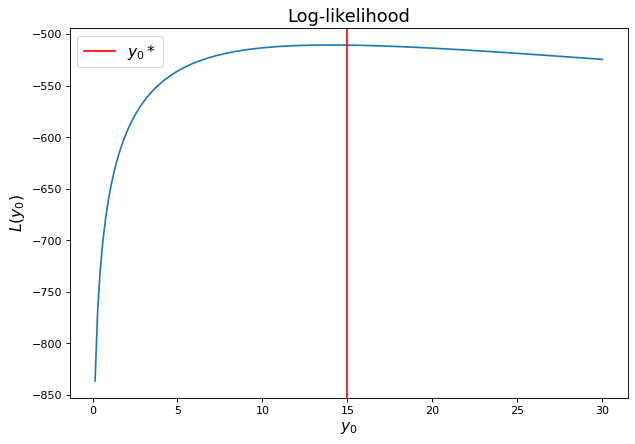

In [233]:
import matplotlib.pyplot as plt

tab_y0=np.linspace(0,30,200)[1:] # we generate a table for y0 
logl_y0=np.array([loglh(x0_true,y0,x) for y0 in tab_y0]) # we compute the loglh for each value in the table

fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('Log-likelihood', fontsize=16)
plt.xlabel('$y_0$', fontsize=14)
plt.ylabel('$L(y_0)$', fontsize=14)
plt.plot(tab_y0,logl_y0)
plt.axvline(y0_true,color="r",label='$y_0*$')
plt.legend(fontsize=14);

We see that there’s a maximum near the true value, but it's not easy to see since we are working with logs.

However, if we compute the exponential we can get the shape of the posterior $p(y_0 | \{x_k\}, 20)$ (to get the true posterior – a distribution – we would need to find the normalizing factor, which is irrelevant here)

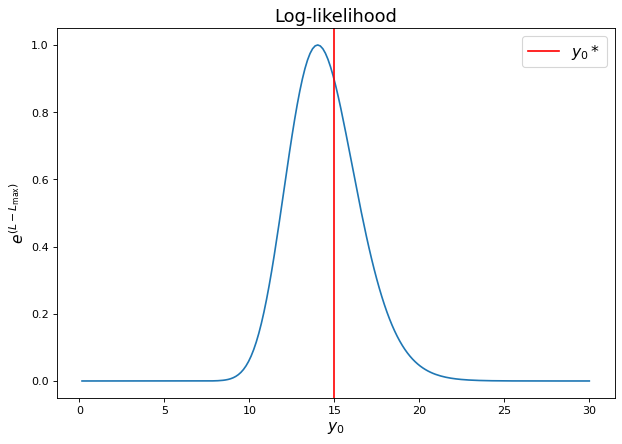

In [234]:
fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('Log-likelihood', fontsize=16)
plt.xlabel('$y_0$', fontsize=14)
plt.ylabel('$e^{(L-L_{\max})}$', fontsize=14)
plt.plot(tab_y0,np.exp(logl_y0-max(logl_y0)))
plt.axvline(y0_true,color="r",label='$y_0*$')
plt.legend(fontsize=14);

##### Now we compute the maximum likelihood estimator for $y_0$, that we call $\widehat{y}_{0,ML}$, and we see how it behaves when we vary the number of data in the sample $x$

A good way to compute the maximum of a function is to use a function from `scipy.optimize` called `minimize`

In [235]:
%%time
from scipy.optimize import minimize

tab_N = np.logspace(0, 4, num=10, base=10)
y0_ML=[]
for N in tab_N:
  x=cauchy.rvs(loc=x0_true,scale=y0_true,size=int(N))
  y0_guess = np.random.uniform(0,30) # we have to give a guess for the minimizer algorithm to start
  optimum = minimize(lambda y0:-loglh(x0_true,y0,x),y0_guess, method='Nelder-Mead')
  y0_ML.append(optimum.x)

CPU times: total: 1.17 s
Wall time: 5.12 s


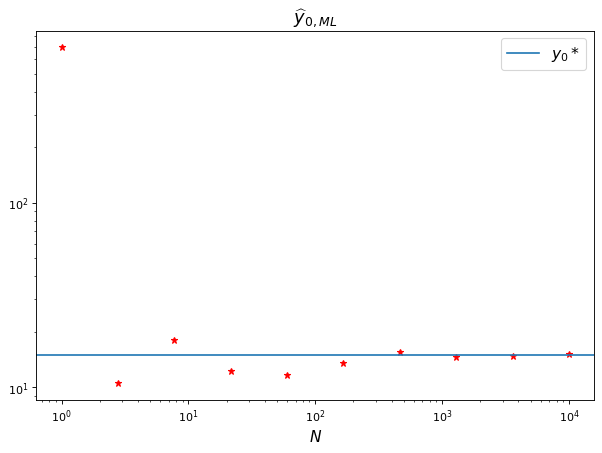

In [236]:
fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('$\widehat{y}_{0,ML}$', fontsize=16)
plt.xlabel('$N$', fontsize=14)
plt.plot(tab_N,y0_ML,"*",color='r')
plt.axhline(y0_true, label="$y_0*$")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=14);

#### 2) Now do the same, but in the case in which we know $y_0 = 15$ but we do not know $x_0$, that is again $20$:
* Generate $N=100$ samples Cauchy-distributed according to the same parameters $x_0$ and $y_0$
* Plot  the Log-likelihood for a range of values of $x_0$ around the true value $x_0^*$
* Compute the maximum likelihood estimator for $x_0$ , that we call $\widehat{x}_0$ , and see how it behaves for $N\in[1,10^4]$




In [237]:
N=100
x0_true=20
y0_true=15

y=cauchy.rvs(loc=x0_true,scale=y0_true,size=N)

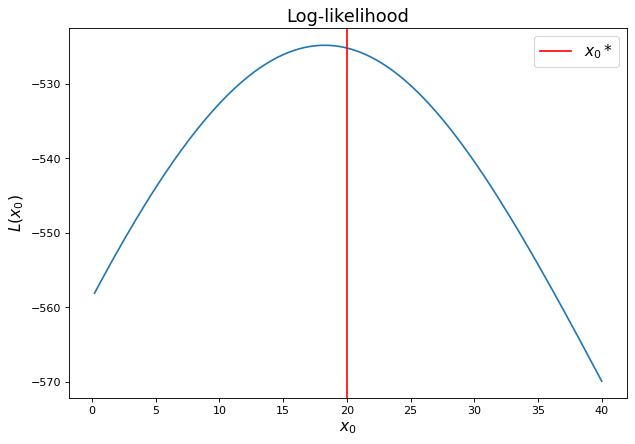

In [238]:
tab_x0=np.linspace(0,40,200)[1:] # we generate a table for y0 
logl_x0=np.array([loglh(x0,y0_true,y) for x0 in tab_x0]) # we compute the loglh for each value in the table

fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('Log-likelihood', fontsize=16)
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$L(x_0)$', fontsize=14)
plt.plot(tab_x0,logl_x0)
plt.axvline(x0_true,color="r",label='$x_0*$')
plt.legend(fontsize=14);

In [239]:
%%time

tab_N = np.logspace(0, 4, num=10, base=10)
x0_ML=[]
for N in tab_N:
  y=cauchy.rvs(loc=x0_true,scale=y0_true,size=int(N))
  x0_guess = np.random.uniform(0,30) # we have to give a guess for the minimizer algorithm to start
  optimum = minimize(lambda x0:-loglh(x0,y0_true,y),x0_guess, method='Nelder-Mead')
  x0_ML.append(optimum.x)


CPU times: total: 1.92 s
Wall time: 7.83 s


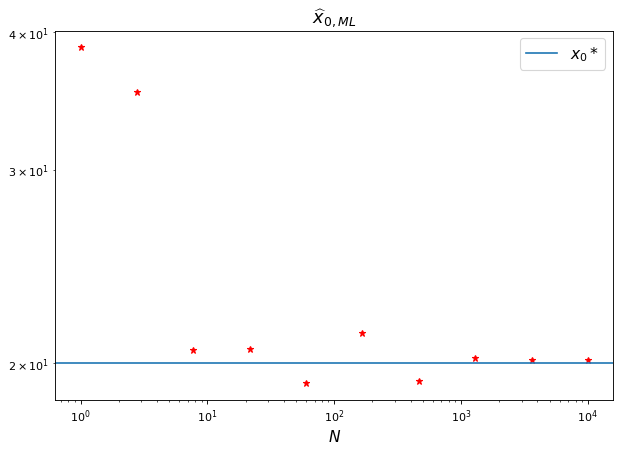

In [240]:
fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('$\widehat{x}_{0,ML}$', fontsize=16)
plt.xlabel('$N$', fontsize=14)
plt.plot(tab_N,x0_ML,"*",color='r')
plt.axhline(x0_true, label="$x_0*$")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=14);

#### 3) Now, after having generated data for N in $[1,10^7]$, try to compute the mean $\left<x\right>$ for each sample as a function of $N$. What do you observe? What about the median?

In [241]:
tab_N = np.logspace(0, 7, num=10, base=10)
print(tab_N)

[1.00000000e+00 5.99484250e+00 3.59381366e+01 2.15443469e+02
 1.29154967e+03 7.74263683e+03 4.64158883e+04 2.78255940e+05
 1.66810054e+06 1.00000000e+07]


In [242]:
tab_N = np.logspace(0, 7, num=10, base=10)
mean=np.zeros(10)
median=np.zeros(10)
i=0
for N in tab_N:
  x=cauchy.rvs(loc=x0_true,scale=y0_true,size=int(N))
  mean[i] = np.mean(x)
  median[i]=np.median(x)
  i+=1



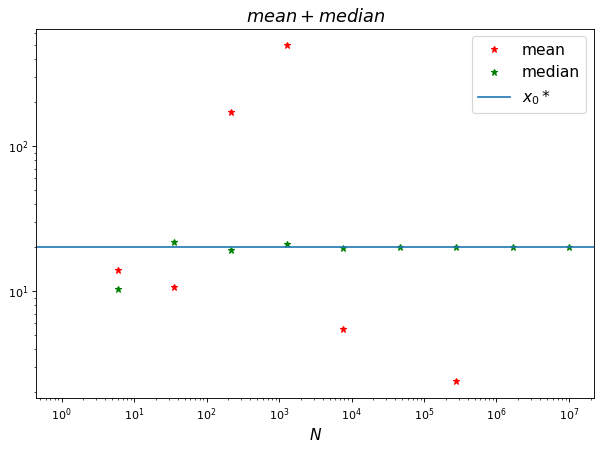

In [243]:
fig = plt.figure(figsize=(9,6), dpi=80)
plt.title('$ mean+median $', fontsize=16)
plt.xlabel('$N$', fontsize=14)
plt.plot(tab_N,mean,"*",color='r', label= 'mean')
plt.plot(tab_N,median,"*",color='g', label= 'median')
plt.axhline(x0_true, label="$x_0*$")
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=14);

**We can observe that the mean is not converging to the solution but the median is**

## MSE: which estimator is the best?

First of all, let's recall the definition:

**Mean Squared Error**: The mean square error (MSE) is the expectation
value of the square of the difference beween the estimator and the true value of parameter.

$$MSE(\widehat{\lambda};\lambda) \equiv \mathop{\mathbb{E}_{\widehat{\lambda}}}\big[ (\widehat{\lambda} - \lambda)^2 \big]$$

#### **FISHER INFORMATION**

As we recalled earlier, for $N$ independent events we have
$$
I_N(\lambda)=\sum_{i=1}^N I(\lambda) = NI(\lambda).
$$

Therefore for our problem

$$
I_N(x_0, y_0) = N \mathbb{E}_x[S(x|x_0)^2] = -N \mathbb{E}_x\begin{bmatrix}\frac{\partial^2 L}{\partial x_0^2} & \frac{\partial^2 L}{\partial x_0\partial y_0}\\ \frac{\partial^2 L}{\partial y_0\partial x_0} & \frac{\partial^2 L}{\partial y_0^2}\end{bmatrix}
$$

And after a bit of computations, and a little help from [wolfram alpha](https://www.wolframalpha.com/calculators/integral-calculator/), one finds that if $x \in(-\infty,+\infty)$ then the Fisher information is

$$I_N(x_0, y_0) =\begin{bmatrix}\frac{N}{2y_0^2} & 0\\0 & \frac{N}{2y_0^2}\end{bmatrix} = \frac{N}{2y_0^2} \mathbb{I}_2$$

And therefore

*   $\det [I_N(x_0,y_0)] = \frac{N^2}{4y_0^4}$
*   $I_N(y_0|x_0) = \frac{N}{2y_0^2}$
*   $I_N(x_0|y_0) = \frac{N}{2y_0^2} = \text{const}$



#### **CRAMÉR-RAO BOUND**

For **unbiased estimators**, as for example the maximum likelihood one, the CRB tells us that for each parameter $\lambda_i$ we have

$$MSE(\widehat{\lambda_i}_{ML};\lambda_i) \geq \{[I_N(\mathbf{\lambda})]^{-1}\}_{ii}$$

where $I_N(\mathbf{\lambda})$ is the Fisher information.

#### **JEFFREYS PRIOR**

In general, the Jeffreys prior is given by

$$p(\mathbf{\lambda}) \propto \sqrt{\det[I_N(\mathbf{\lambda})]}$$

In this case the Cramér-Rao bound tells us:

$$MSE(\widehat{y_0}_{ML};y_0) \geq \frac{2y_0^2}{N}$$

While the Jeffreys prior, normalized, is $p(y_0) = \frac{1}{y_0}$ and thus the posterior 

$$p(y_0 | \{x_k\}, x_0) \propto p(\{x_k\} | y_0, x_0) p(y_0) \propto \frac{1}{y_0}\prod_{i=1}^{N}  \frac{1}{\pi} \frac{y_0}{(x_i-x_0)^2 + y_0^2}$$

#### Consider the case in which $x_0=20$, and we know its value, and we want to estimate $y_0$

Now let's compute the MSE on the likelihood estimator and on the one found with Jeffreys prior, and compare the two with the Cramér-Rao bound

Firstly, we define the function to compute the posterior with Jeffreys prior

In [244]:
def jeffpost(x0,y0,x):
  jp= - np.log(y0) #prior
  for i in x: jp+=np.log(y0/((y0**2+(i-x0)**2)*np.pi))
  return jp

Since we are going to use it a lot of times, we define a new function `minimizer_y0` to compute the estimators given a function to minimize  

In [245]:
def minimizer_y0(func,y0):
  y0_est=np.zeros(N_rep)
  for ir in range(N_rep):
    x=cauchy.rvs(loc=x0_true,scale=y0,size=N)
    y0_est[ir] = minimize(lambda y:-func(x0_true,y,x),np.random.uniform(0,30), method='Nelder-Mead').x
  return y0_est;

To estimate the $MSE$, i.e. to compute the expected value over $\widehat{\lambda}$, we need to repeat the estimation $N_{rep}$ times. We will do this for $N_{est} = 15$ values of $y_0$ in $(0,1]$, starting with $N=10$ and $N_{rep} = 500$

In [246]:
N_est=15
tab_y0=np.linspace(0,1,N_est+1)[1:]
N = 10
N_rep = 500

In [247]:
%%time

y0_ML= np.array([ minimizer_y0(loglh,y0) for y0 in tab_y0])
y0_J= np.array([ minimizer_y0(jeffpost,y0) for y0 in tab_y0])

C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: invalid value encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: divide by zero encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: invalid value encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: divide by zero encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:3: RuntimeWarning: invalid value encountered in add
  for i in x: jp+=np.log(y0/((y0**2+(i-x0)**2)*np.pi))


CPU times: total: 16.7 s
Wall time: 1min 6s


Now that we have computed $N_{rep}$ estimates for each value of $y_0$ with both methods, we can estimate the $MSE$ and we can use **bootstrap** to give a confidence interval on our estimations

First we define the function `MSE_est`
that, given the array of $N_{rep}$ estimates of $y_0$, returns the estimate of the $MSE$ and its C.I.

In [248]:
from numpy import percentile
from numpy.random import choice

def MSE_est(y0_est,y0):
  N_boot=100
  MSE = (y0_est - np.full(N_rep, y0))**2 #avoid for loops!
  MSE_mean = MSE.mean()
  MSE_boot = choice(MSE,(N_boot,N_rep))
  MSE_boot_mean = MSE_boot.mean(axis=1)
  CI_min = percentile(MSE_boot_mean, [2.5,97.5])[0]
  CI_max = percentile(MSE_boot_mean, [2.5,97.5])[1]

  return MSE_mean, CI_min, CI_max

And now we can compute our estimates for each $y_0$

In [249]:
MSE_ML_10 = np.zeros(N_est)
CI_min_ML_10 = np.zeros(N_est)
CI_max_ML_10 = np.zeros(N_est)
MSE_J_10 = np.zeros(N_est)
CI_min_J_10 = np.zeros(N_est)
CI_max_J_10 = np.zeros(N_est)

for j,y0 in enumerate(tab_y0):
  MSE, CI_min, CI_max = MSE_est(y0_ML[j], y0)
  MSE_ML_10[j] = MSE
  CI_min_ML_10[j] = CI_min
  CI_max_ML_10[j] = CI_max
  MSE, CI_min, CI_max = MSE_est(y0_J[j], y0)
  MSE_J_10[j] = MSE
  CI_min_J_10[j] = CI_min
  CI_max_J_10[j] = CI_max

And compare them to the Cramér-Rao bound

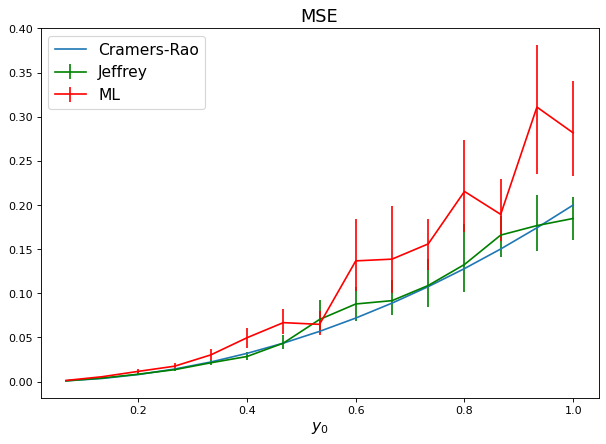

In [250]:
fig = plt.figure(figsize=(9, 6), dpi=80)

plt.title('MSE', fontsize=16)
plt.xlabel('$y_0$', fontsize=14)
plt.errorbar(tab_y0,MSE_J_10,yerr=[MSE_J_10-CI_min_J_10, CI_max_J_10-MSE_J_10],marker="",color='g', label='Jeffrey')
plt.errorbar(tab_y0,MSE_ML_10,yerr=[MSE_ML_10-CI_min_ML_10, CI_max_ML_10-MSE_ML_10],marker="",color='r', label='ML')
plt.plot(tab_y0, 2*tab_y0*tab_y0/N, label='Cramers-Rao')
plt.legend(fontsize=14)

#### 4) Now do the same for $N=3$ and $N=50$ and plot all in a single graph, to see what happens when we vary $N$

**N=3**

In [251]:
N_est=15
tab_y0=np.linspace(0,1,N_est+1)[1:]
N = 3
N_rep = 500

In [252]:
%%time

y0_ML= np.array([ minimizer_y0(loglh,y0) for y0 in tab_y0])
y0_J= np.array([ minimizer_y0(jeffpost,y0) for y0 in tab_y0])

C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: invalid value encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: divide by zero encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: invalid value encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: divide by zero encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:3: RuntimeWarning: invalid value encountered in add
  for i in x: jp+=np.log(y0/((y0**2+(i-x0)**2)*np.pi))


CPU times: total: 12.2 s
Wall time: 31.7 s


In [253]:
MSE_ML_3 = np.zeros(N_est)
CI_min_ML_3 = np.zeros(N_est)
CI_max_ML_3 = np.zeros(N_est)
MSE_J_3 = np.zeros(N_est)
CI_min_J_3 = np.zeros(N_est)
CI_max_J_3 = np.zeros(N_est)

for j,y0 in enumerate(tab_y0):
  MSE, CI_min, CI_max = MSE_est(y0_ML[j], y0)
  MSE_ML_3[j] = MSE
  CI_min_ML_3[j] = CI_min
  CI_max_ML_3[j] = CI_max
  MSE, CI_min, CI_max = MSE_est(y0_J[j], y0)
  MSE_J_3[j] = MSE
  CI_min_J_3[j] = CI_min
  CI_max_J_3[j] = CI_max



**N=50**

In [254]:
N_est=15
tab_y0=np.linspace(0,1,N_est+1)[1:]
N = 50
N_rep = 500

In [255]:
%%time

y0_ML= np.array([ minimizer_y0(loglh,y0) for y0 in tab_y0])
y0_J= np.array([ minimizer_y0(jeffpost,y0) for y0 in tab_y0])

C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: invalid value encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: divide by zero encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: invalid value encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: divide by zero encountered in log
  jp= - np.log(y0) #prior
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:3: RuntimeWarning: invalid value encountered in add
  for i in x: jp+=np.log(y0/((y0**2+(i-x0)**2)*np.pi))


CPU times: total: 1min 30s
Wall time: 4min 21s


In [256]:
MSE_ML_50 = np.zeros(N_est)
CI_min_ML_50 = np.zeros(N_est)
CI_max_ML_50 = np.zeros(N_est)
MSE_J_50 = np.zeros(N_est)
CI_min_J_50 = np.zeros(N_est)
CI_max_J_50 = np.zeros(N_est)

for j,y0 in enumerate(tab_y0):
  MSE, CI_min, CI_max = MSE_est(y0_ML[j], y0)
  MSE_ML_50[j] = MSE
  CI_min_ML_50[j] = CI_min
  CI_max_ML_50[j] = CI_max
  MSE, CI_min, CI_max = MSE_est(y0_J[j], y0)
  MSE_J_50[j] = MSE
  CI_min_J_50[j] = CI_min
  CI_max_J_50[j] = CI_max



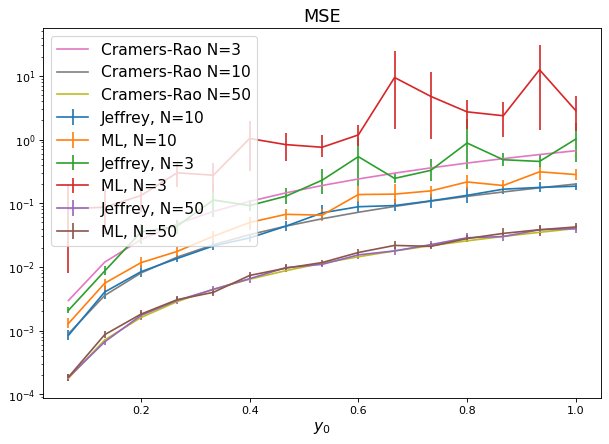

In [257]:
fig = plt.figure(figsize=(9, 6), dpi=80)
plt.title('MSE', fontsize=16)
plt.xlabel('$y_0$', fontsize=14)
plt.errorbar(tab_y0,MSE_J_10,yerr=[MSE_J_10-CI_min_J_10, CI_max_J_10-MSE_J_10],marker="", label='Jeffrey, N=10')
plt.errorbar(tab_y0,MSE_ML_10,yerr=[MSE_ML_10-CI_min_ML_10, CI_max_ML_10-MSE_ML_10],marker="", label='ML, N=10')


plt.errorbar(tab_y0,MSE_J_3,yerr=[MSE_J_3-CI_min_J_3, CI_max_J_3-MSE_J_3],marker="", label='Jeffrey, N=3')
plt.errorbar(tab_y0,MSE_ML_3,yerr=[MSE_ML_3-CI_min_ML_3, CI_max_ML_3-MSE_ML_3],marker="", label='ML, N=3')

plt.errorbar(tab_y0,MSE_J_50,yerr=[MSE_J_50-CI_min_J_50, CI_max_J_50-MSE_J_50],marker="", label='Jeffrey, N=50')
plt.errorbar(tab_y0,MSE_ML_50,yerr=[MSE_ML_50-CI_min_ML_50, CI_max_ML_50-MSE_ML_50],marker="", label='ML, N=50')


plt.plot(tab_y0, 2*tab_y0*tab_y0/3, label='Cramers-Rao N=3')
plt.plot(tab_y0, 2*tab_y0*tab_y0/10, label='Cramers-Rao N=10')
plt.plot(tab_y0, 2*tab_y0*tab_y0/50, label='Cramers-Rao N=50')
plt.yscale('log')
plt.legend(fontsize=14)

#### 5) Now consider the case in which we know the value of $y_0=15$ but not $x_0$:

* What Jeffreys prior tells us in this case?
* Compare the MSE on the maximum likelihood and the median estimators for values of $x_0$ in $[-1,1]$ and compare both to the Cramér-Rao bound
* Repeat the process for $N=3,50$ as before and compare the results

In this case the Cramér-Rao bound tells us that $$MSE(\widehat{x_0}_{ML};x_0) \geq \frac{2x_0^2}{N}$$

While the Jeffreys prior, normalized, is $p(x_0) = \frac{1}{x_0}$ and thus the posterior 

$$p(x_0 | \{x_k\}, y_0) \propto p(\{x_k\} | y_0, x_0) p(x_0) 

In [258]:
def median(x0,yo,x):
  return np.median(x)

def minimizer_x0(func,x0):
  x0_est=np.zeros(N_rep)
  for ir in range(N_rep):
    x=cauchy.rvs(loc=x0,scale=y0_true,size=N)
    x0_est[ir] = minimize(lambda y:-func(x0,y0_true,x),np.random.uniform(0,30), method='Nelder-Mead').x
  return x0_est;




In [259]:
N_est=15
tab_x0=np.linspace(-1,1,N_est+1)[1:]
N = 10
N_rep = 500

In [260]:
x0_ML= np.array([ minimizer_x0(loglh,x0) for x0 in tab_x0])
x0_median = np.array([minimizer_x0(median,x0) for x0 in tab_x0])


In [261]:
MSE_ML_10 = np.zeros(N_est)
CI_min_ML_10 = np.zeros(N_est)
CI_max_ML_10 = np.zeros(N_est)
MSE_MED_10 = np.zeros(N_est)
CI_min_MED_10 = np.zeros(N_est)
CI_max_MED_10 = np.zeros(N_est)

for j,x0 in enumerate(tab_x0):
  MSE, CI_min, CI_max = MSE_est(x0_ML[j], x0)
  MSE_ML_10[j] = MSE
  CI_min_ML_10[j] = CI_min
  CI_max_ML_10[j] = CI_max
  MSE, CI_min, CI_max = MSE_est(x0_median[j], x0)
  MSE_MED_10[j] = MSE
  CI_min_MED_10[j] = CI_min
  CI_max_MED_10[j] = CI_max




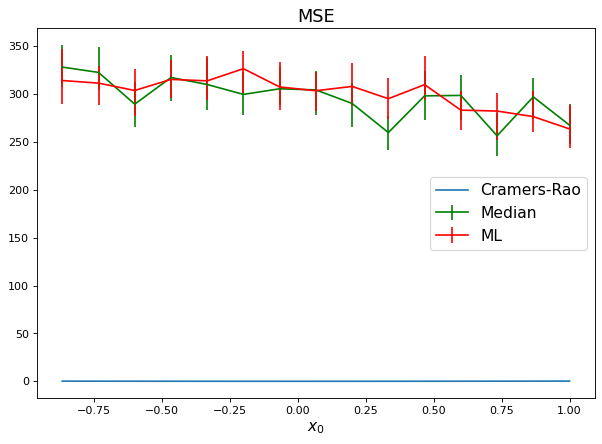

In [262]:
fig = plt.figure(figsize=(9, 6), dpi=80)

plt.title('MSE', fontsize=16)
plt.xlabel('$x_0$', fontsize=14)
plt.errorbar(tab_x0,MSE_MED_10,yerr=[MSE_MED_10-CI_min_MED_10, CI_max_MED_10-MSE_MED_10],marker="",color='g', label='Median')
plt.errorbar(tab_x0,MSE_ML_10,yerr=[MSE_ML_10-CI_min_ML_10, CI_max_ML_10-MSE_ML_10],marker="",color='r', label='ML')
plt.plot(tab_x0, 2*tab_x0*tab_x0/N, label='Cramers-Rao')
plt.legend(fontsize=14)

**N=3**

**N=50**

## Estimate both the parameters
Now we consider again the case with $y_0=15$, $x_0=20$, but let's assume that we do not know either $x_0$, $y_0$. 

If we assume that both $x_0$ and $y_0$ are uniform over some interval, then the posterior is simply proportional to the likelihood:
$$p(x_0, y_0 | \{x_k\}) \propto p(\{x_k\} | x_0, y_0)$$

We make an experiment, by generating $N=100$ samples and we plot the dependence of log-likelyhood as a function of $x_0$ and $y_0$. 

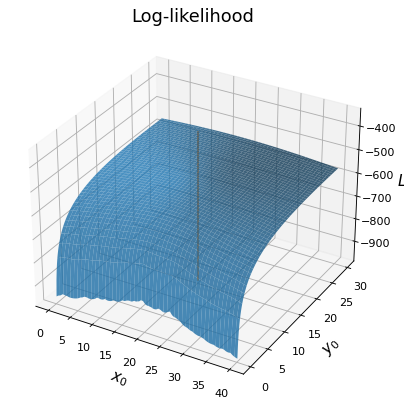

In [263]:
from mpl_toolkits.mplot3d import Axes3D
x0_true=20
y0_true=15
N=100
tab_y0=np.linspace(0,30,201)[1:]
tab_x0=np.linspace(0,40,200)
x=cauchy.rvs(loc=x0_true,scale=y0_true,size=N)
#logl=[[loglh(x0,y,x) for y in taby0] for x0 in tabx0]

fig = plt.figure(figsize=(9,6), dpi=80)
ax = fig.add_subplot(111, projection='3d') #we create the 3d axis
plt.title('Log-likelihood', fontsize=16)
X, Y = np.meshgrid(tab_x0,tab_y0)
zs = np.array(loglh(np.ravel(X), np.ravel(Y),x))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.8)
ax.plot( np.full(1000, x0_true), np.full(1000, y0_true), np.linspace(max(zs)+200, min(zs), 1000))

ax.set_xlabel('$x_0$', fontsize=14)
ax.set_ylabel('$y_0$', fontsize=14)
ax.set_zlabel('$L$', fontsize=14)

plt.show()


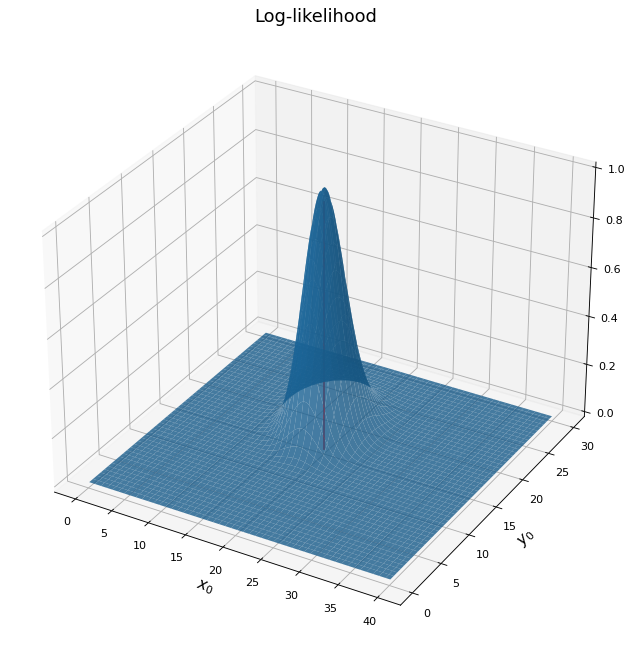

In [264]:
fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')
plt.title('Log-likelihood', fontsize=16)
X, Y = np.meshgrid(tab_x0,tab_y0)
zslog = np.array(np.exp(loglh(np.ravel(X), np.ravel(Y),x) - max(zs)))
Z = zslog.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.8)
ax.plot( np.full(1000, x0_true), np.full(1000, y0_true), np.linspace(0,1, 1000),color='r')

ax.set_xlabel('$x_0$', fontsize=14)
ax.set_ylabel('$y_0$', fontsize=14)


plt.show()


##### And finally we compute the ML estimator of both the parameters

In [265]:
%%time
tab_N= np.logspace(0, 4, base=10, num=20)
y0_ML=[]
x0_ML=[]

def f(params):
  x0,y0 = params
  return -loglh(x0,y0,x)

for N in tab_N:
  x=cauchy.rvs(loc=x0_true,scale=y0_true,size=int(N))
  xy0 = (np.random.uniform(0,40),np.random.uniform(0,30))
  #bounds = [(-40,40),(0,50)]
  optimum = minimize(f,xy0, method='Nelder-Mead')
  x0_ML.append(optimum.x[0])
  y0_ML.append(optimum.x[1])



C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: invalid value encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)


CPU times: total: 1.94 s
Wall time: 5.46 s


20 20 20


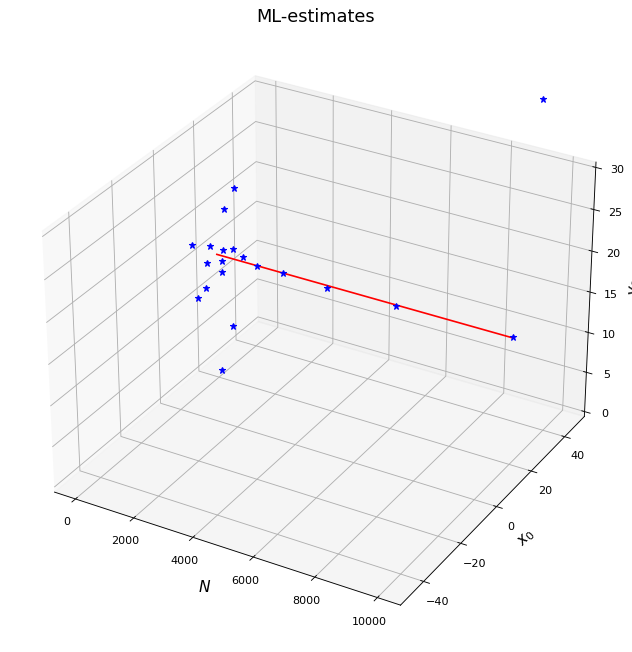

In [266]:
fig = plt.figure(figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')
sizes = np.array([int(N) for N in tab_N])
print(len(sizes),len(x0_ML), len(y0_ML))
plt.title('ML-estimates', fontsize=16)
ax.plot( range(10000), np.full(10000, x0_true), np.full(10000, y0_true),color='r')
ax.plot(tab_N, x0_ML, y0_ML, marker="*",color='b', ls='None')
ax.set_xlabel('$N$', fontsize=14)
ax.set_ylabel('$x_0$', fontsize=14)
ax.set_zlabel('$y_0$', fontsize=14)

ax.set_ylim(-50,50)
ax.set_zlim(0,30)

plt.show()

## Evaluated!

#### 6) Take the dataset you find in `where_is_the_light.npy` file and import it into a numpy array. It contains $N=10000$ Cauchy-distributed samples with unknown parameters $x_0$ and $y_0$. Using the techniques previously showed, give an estimate (with a confidence interval) of the true value of $x_0$ and $y_0$. You are guaranteed that $x_0 \in [-100,100]$ and $y_0 \in [0,30]$. *Bonus*: which one is better between Jefferys prior and uniform prior?

In [267]:
x=np.load("where_is_the_light.npy")


In [268]:
def f(params):
  x0,y0 = params
  return -loglh(x0,y0,x)

def j(params):
  x0,y0 = params
  return -jeffpost(x0,y0,x)

In [269]:
N_rep=15
tab_xy0=[]
x0_ML=[]
y0_ML=[]
x0_J=[]
y0_J=[]
for n in range (N_rep):
  xy0=(np.random.uniform(-100,100),np.random.uniform(0,30))
  tab_xy0.append([xy0[0],xy0[1]])
  optimum = minimize(f,xy0, method='Nelder-Mead')
  x0_ML.append(optimum.x[0])
  y0_ML.append(optimum.x[1])
  optimum_Jeff=minimize(j,xy0, method='Nelder-Mead')
  x0_J.append(optimum_Jeff.x[0])
  y0_J.append(optimum_Jeff.x[1])



C:\Users\manon\AppData\Local\Temp\ipykernel_25188\984721421.py:3: RuntimeWarning: invalid value encountered in log
  for i in x: logl+=np.log(y0/(y0**2+(i-x0)**2)/np.pi)
C:\Users\manon\AppData\Local\Temp\ipykernel_25188\1329403148.py:2: RuntimeWarning: invalid value encountered in log
  jp= - np.log(y0) #prior


**Uniform prior**

In [270]:
CI=percentile(x0_ML, [2.5,97.5])
print(f"The ML estimator for x0 is {np.mean(x0_ML)} and the confidence interval is {CI}")
CI=percentile(y0_ML, [2.5,97.5])
print(f"The ML estimator for y0 is {np.mean(y0_ML)} and the confidence interval is {CI}")


The ML estimator for x0 is 42.85013432835846 and the confidence interval is [42.85009933 42.85018185]
The ML estimator for y0 is 15.746208876588582 and the confidence interval is [15.74616903 15.74625155]


**Jefferys prior**

In [271]:
CI=percentile(x0_J, [2.5,97.5])
print(f"The ML estimator for x0 is {np.mean(x0_J)} and the confidence interval is {CI}")
CI=percentile(y0_J, [2.5,97.5])
print(f"The ML estimator for y0 is {np.mean(y0_J)} and the confidence interval is {CI}")

The ML estimator for x0 is 42.85012808210995 and the confidence interval is [42.8500776  42.85016579]
The ML estimator for y0 is 15.743035155417605 and the confidence interval is [15.74299374 15.74308301]
